In [1]:
# -*- coding: utf-8 -*- 
import numpy as np
import pandas as pd
import matplotlib as mpl 
import matplotlib.pyplot as plt
import proplot as pplt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import joblib
import shap
import lime
import lime.lime_tabular
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.model_selection import KFold, cross_val_score
from sklearn import  metrics
mpl.rcParams.update(
    {
    'font.family': 'sans-serif',            #设置字体样式
    'font.size':16,
    'font.sans-serif': ['SimHei'],        
    'axes.labelsize': 16,
    'xtick.labelsize':16,
    'ytick.labelsize':16
    }
    )          
plt.rcParams['axes.unicode_minus'] = False   #用来正常显示负号

#### 2.1统计分析

In [2]:
# 数据读取
data = pd.read_excel(r'../数据/附件.xlsx', sheet_name= '表单1').iloc[:, 1:]
# 统计分析表1特征
data_K = data[data['类型'] == '高钾'].drop(columns= '类型')
data_Pb = data[data['类型'] == '铅钡'].drop(columns= '类型')
#高钾玻璃
K_dec = data_K.groupby(by= '纹饰').size()
K_color = data_K.groupby(by= '颜色').size()
K_cloud = data_K.groupby(by= '表面风化').size()
#铅钡玻璃
Pb_dec = data_Pb.groupby(by= '纹饰').size()
Pb_color = data_Pb.groupby(by= '颜色').size()
Pb_cloud = data_Pb.groupby(by= '表面风化').size()
#合并
dec = pd.DataFrame(data= {'K':K_dec/len(data_K), 'Pb':Pb_dec/len(data_Pb)}).fillna(0).reset_index()   #重置索引
color = pd.DataFrame(data= {'K':K_color/len(data_K), 'Pb':Pb_color/len(data_Pb)}).fillna(0).reset_index()
cloud = pd.DataFrame(data= {'K':K_cloud/len(data_K), 'Pb':Pb_cloud/len(data_Pb)}).fillna(0).reset_index()
dec.index = dec.iloc[:, 0].values
color.index = color.iloc[:, 0].values
cloud.index = cloud.iloc[:, 0].values
dec.drop(columns='纹饰', inplace= True)
color.drop(columns='颜色', inplace= True)
cloud.drop(columns='表面风化', inplace= True)

Calling arbitrary axes methods from SubplotGrid was deprecated in v0.8 and will be removed in a future release. Please index the grid or loop over the grid instead.


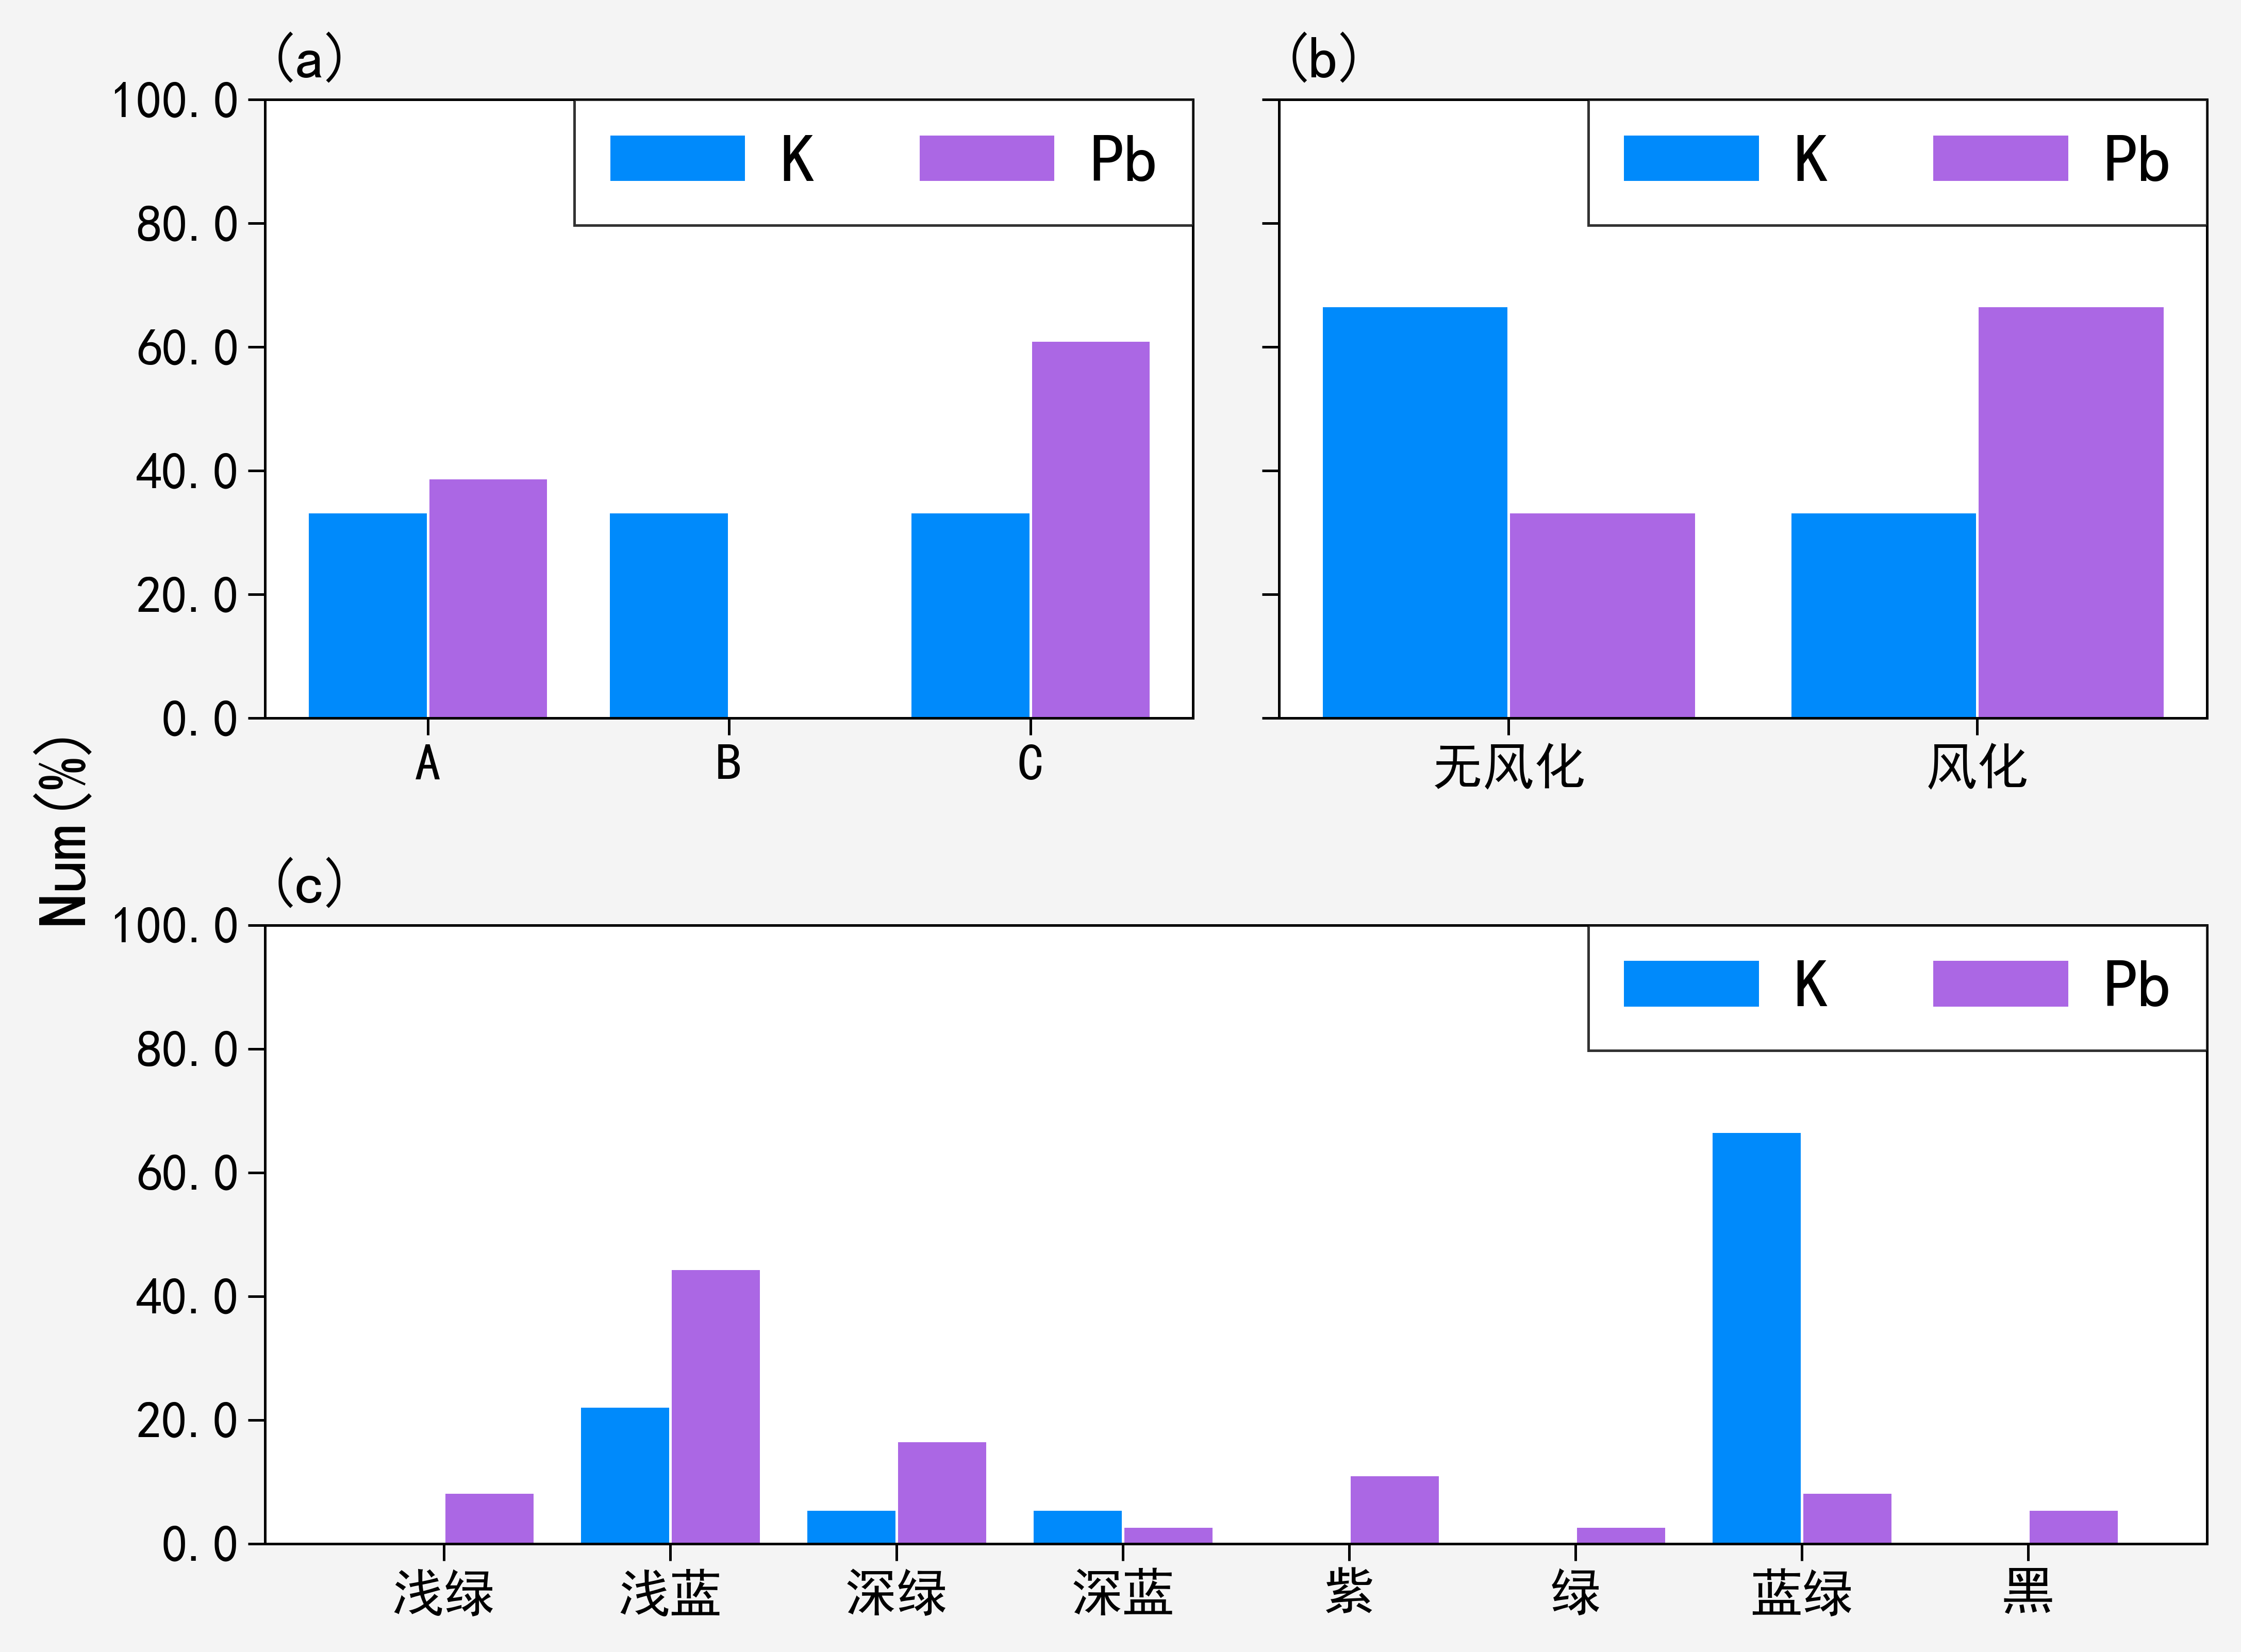

In [7]:
# 绘图  
fig, ax = pplt.subplots([[1,2],[3,3]],refheight= 2,refwidth= 3, dpi= 300)
ax[0].bar(dec*100, cycle= ['#008afb','#ab67e4'], edgecolor='white')
ax[1].bar(cloud*100,cycle= ['#008afb','#ab67e4'], edgecolor='white')
ax[2].bar(color*100,cycle= ['#008afb','#ab67e4'], edgecolor='white')
# 总体设置
ax.legend(loc= 'best')
ax.format(ylim=(0, 100), ytickminor=False, ylocator=20, yformatter='{x:.1f}',
          ylabel= 'Num(%)',ylabelsize= 16,yticklabelsize= 12,xticklabelsize= 12,
          abc= '(a)', abcsize= 14,grid= False, abcweight ='light')
# plt.savefig('../图片/Q2_1_类别与其余文本特征统计结果_表1各类占比.png',dpi= 300)

##### 表2-2

In [13]:
# 数据读取
data = pd.read_excel(r'../数据/附件.xlsx', sheet_name= '表单2').iloc[:, 3:-1].fillna(0)
data.drop(columns= '表面风化', inplace= True)
data_target = data.iloc[:, 0]
data_train = data.iloc[:, 1:]
# data_train = data.iloc[:, [1,4,5,6,8,11]]
x_train, x_test, y_train, y_test = train_test_split(data_train, data_target, test_size= 0.2, random_state= 100)
# 分类
clf = XGBClassifier()
clf.fit(x_train, y_train)
y_pre = clf.predict(x_test)
y_pre_train = clf.predict(x_train)       
print('训练集准确率：', accuracy_score(y_train, y_pre_train))
print('测试集准确率：', accuracy_score(y_test, y_pre))
# joblib.dump(filename=  'XGBoost.model', value= clf) #保存模型

[06:41:54] WARNING: D:\Build\xgboost\xgboost-1.5.1.git\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
训练集准确率： 1.0
测试集准确率： 1.0


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


##### 解释说明模型Lime

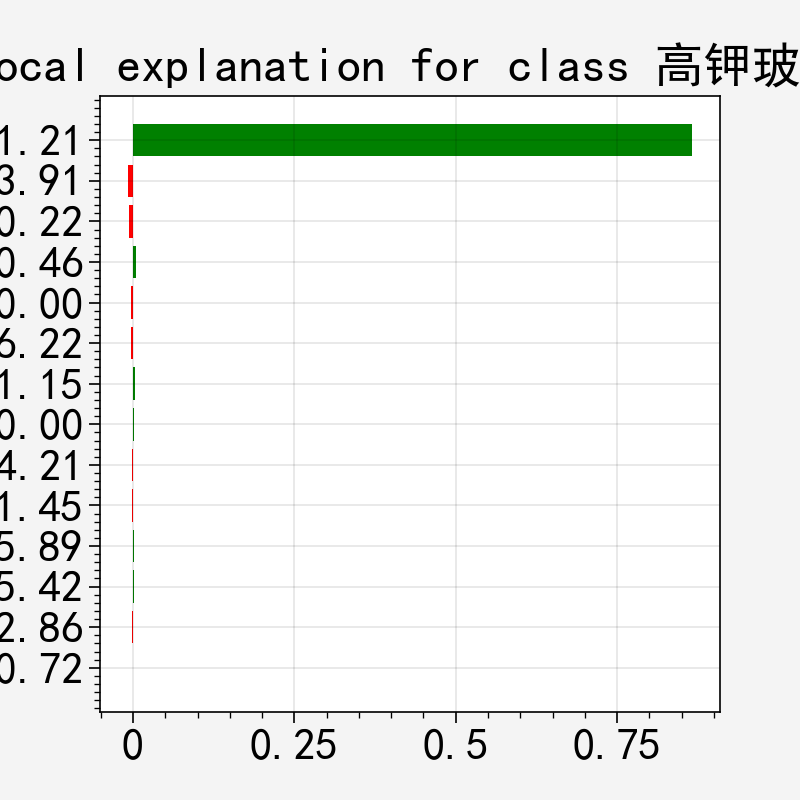

In [14]:
# lime
explainer = lime.lime_tabular.LimeTabularExplainer(np.array(data_train), 
                                                   feature_names = data_train.columns, 
                                                   class_names=['铅钡玻璃','高钾玻璃'],
                                                #    verbose= True,
                                                   mode= 'classification')
exp = explainer.explain_instance(data_row= data[data['类型'] == '高钾'].iloc[:, 1:].mean(skipna= True), \
                                 predict_fn= clf.predict_proba, num_features=14)
fig = exp.as_pyplot_figure()
# plt.savefig(r'../图片/Q2_1_两类玻璃分类规律_表2_LIME权重.svg',dpi=300)
# exp.show_in_notebook(show_table=True)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


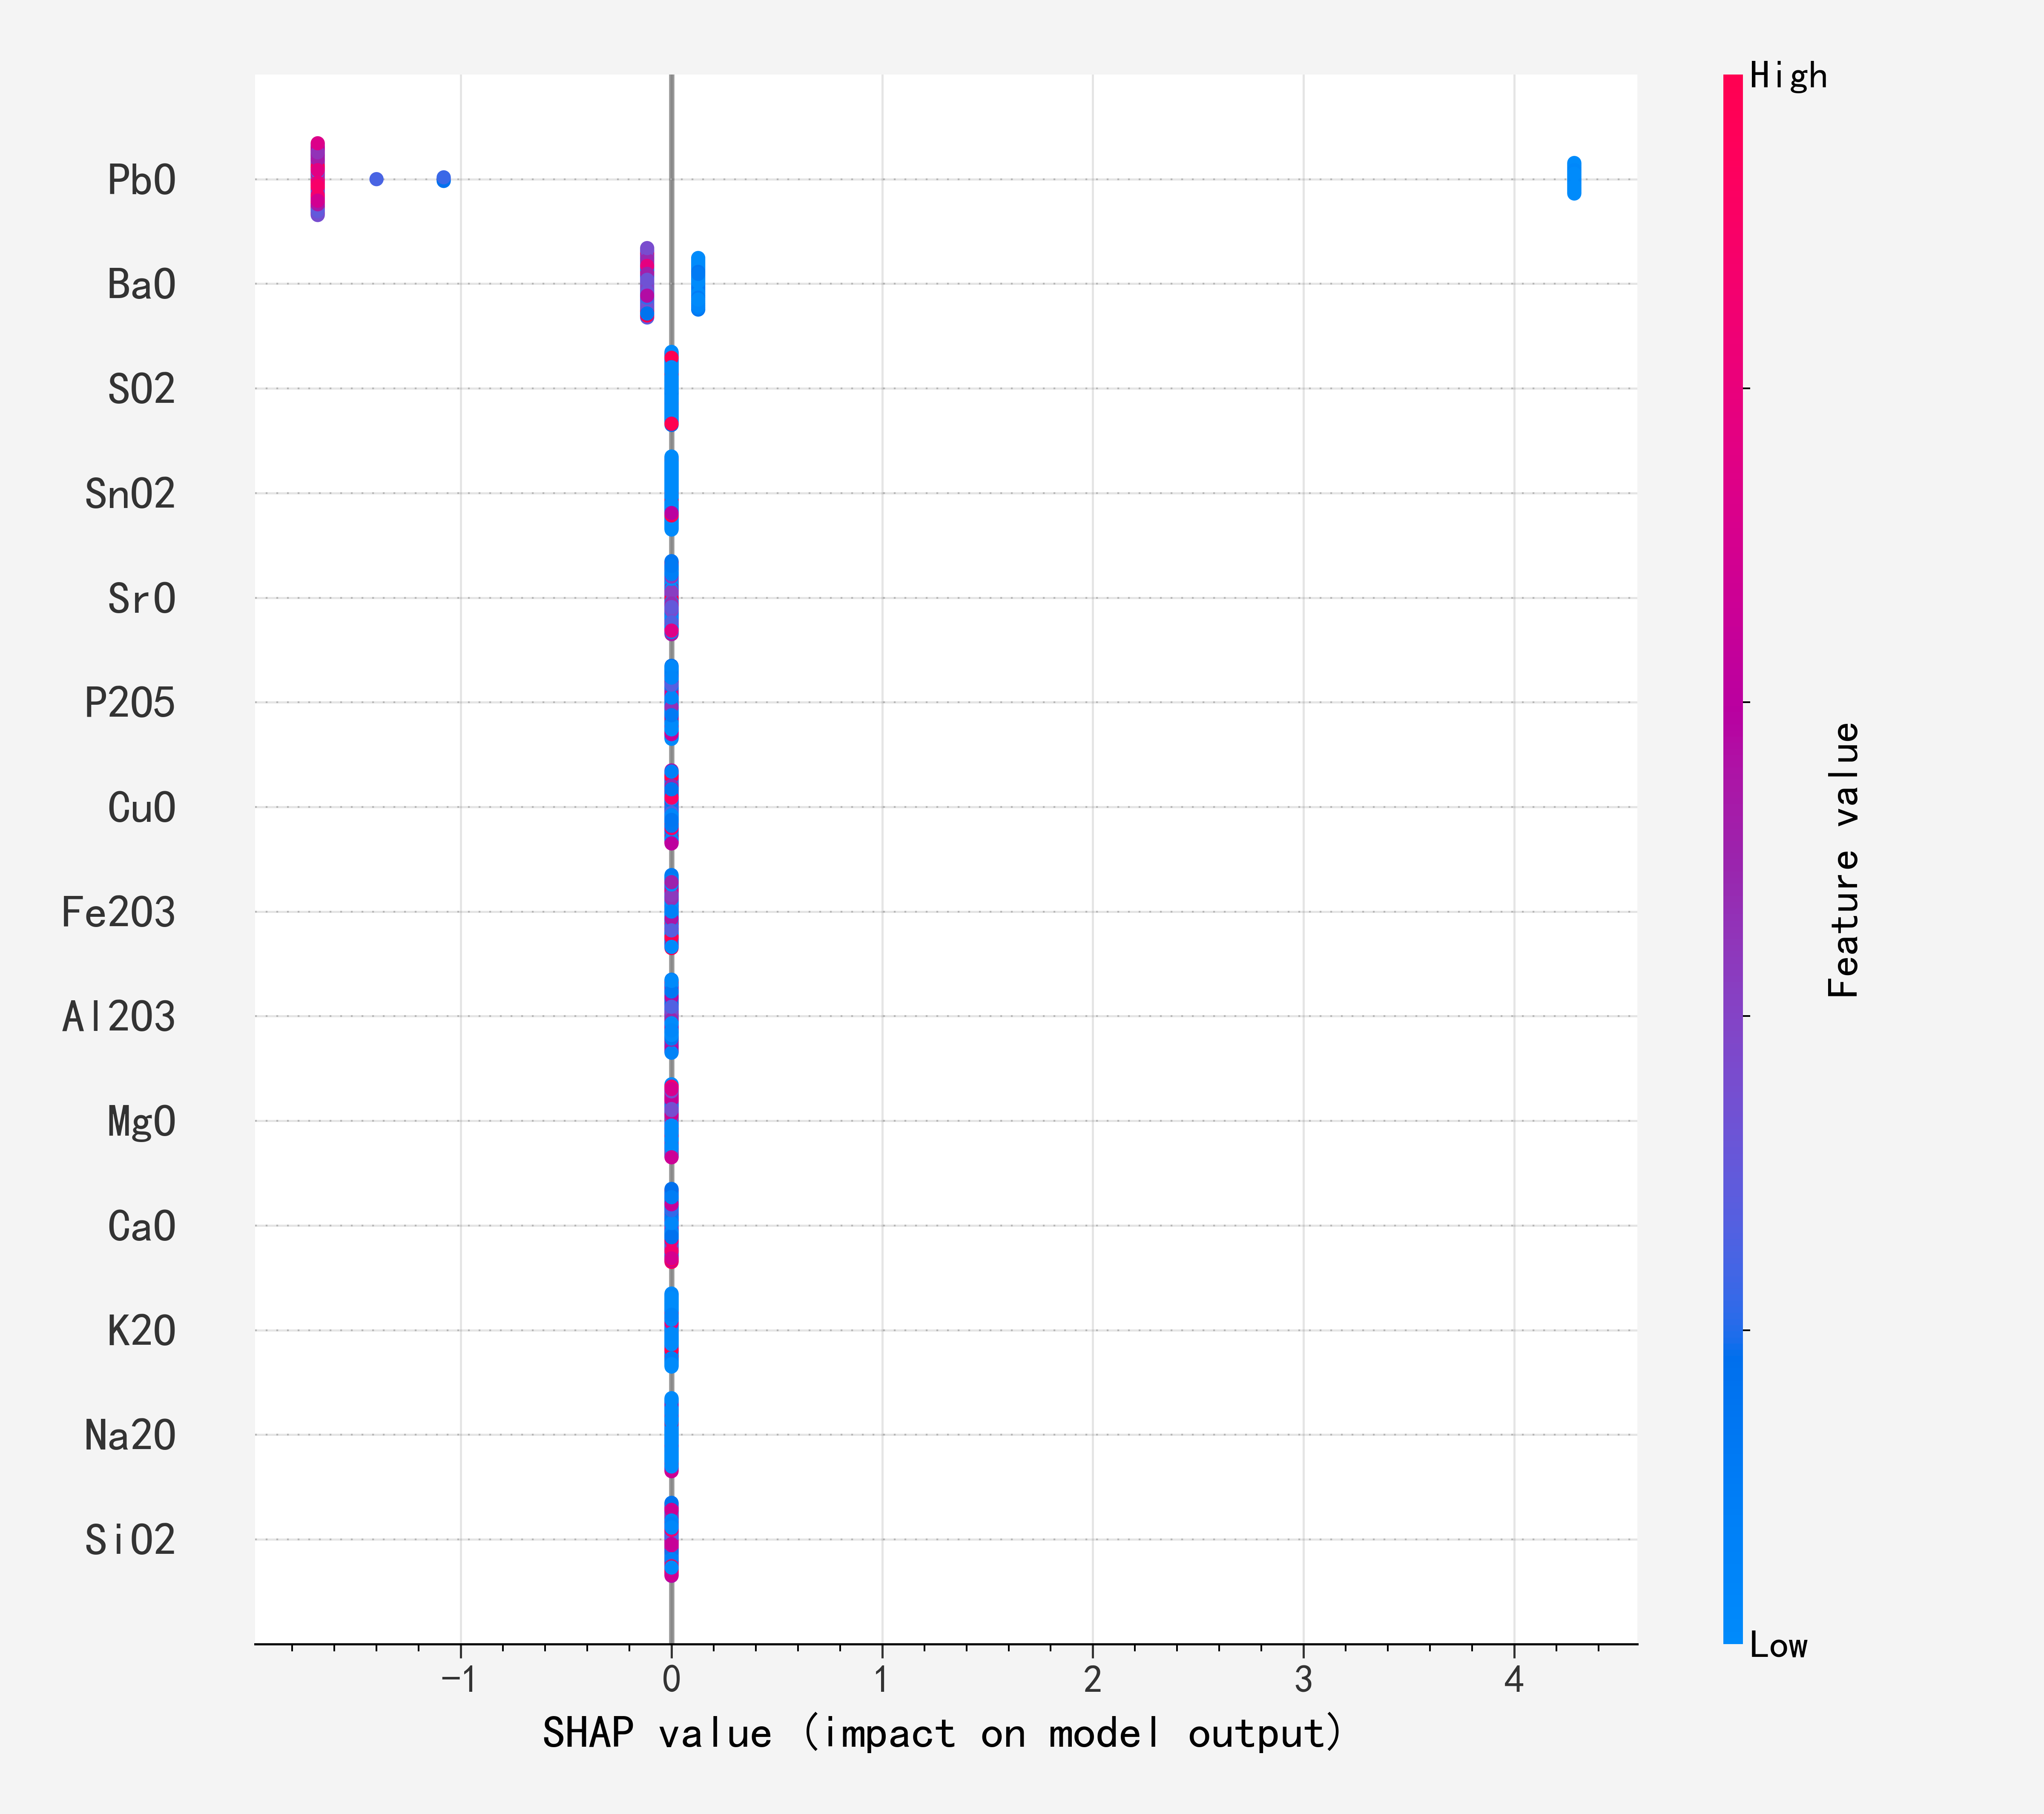

In [15]:
# shap
plt.figure(dpi= 300)
explainer = shap.Explainer(clf)
shap_values = explainer(data_train)
# 整体化学组分
shap.summary_plot(shap_values, data_train)

# shap.force_plot(explainer.expected_value, shap_values[0].values, data_train.iloc[0,:])
# shap.force_plot(explainer.expected_value, shap_values.values, data_train)

# 单样本-PbO
# shap.dependence_plot('PbO', shap_values.values, data_train)

#### 2.2亚类划分-基于变差系数与相对变率

In [2]:
# 规定变差系数Vp>0.8即可根据该变量划分亚类, 相对变率Vr>4.0即可视为一类
# 读取数据-无风化
data = pd.read_excel(r'../数据/表2_update.xlsx', index_col= '文物采样点')
data = data[data['类型']=='高钾'].iloc[:, 4:]
# 变差系数与相对变率计算
Vp = data.std(skipna= True)/data.mean(skipna= True) #14个化学成分的变差系数
chem_vars = Vp[Vp>=0.8].index              #划分亚类的根据变量
Va = np.abs(data-data.mean(skipna= True))/(len(data)-data.isna().sum()) #14个化学成分的绝对变率
Vr = Va/data.mean(skipna= True) * 100               #各个数据的相对变率(%)
print('lenth of data:',len(data))

# 循环遍历分类的变量--查找显著不同的数据的位置
pos = pd.DataFrame()  #用于合并的空df
for i in chem_vars:
    Vr_temp = Vr[i]
    pos_temp = pd.DataFrame(data= {i:Vr_temp[Vr_temp>= 4 ].index.values})
    pos = pd.concat([pos, pos_temp], axis= 1)
    pos_i = pos.loc[:, i].dropna()
    data_pos = data.loc[pos_i, i]
    print('化学成分{}可分类数据:\n'.format(i), data_pos.sort_values())
    print('----------------------------分隔符---------------------------\n')
    # data_pos.sort_values().to_excel(r'../数据/Q2_亚分类_高钾_{}.xlsx'.format(i))

lenth of data: 18
化学成分Fe2O3可分类数据:
 文物采样点
07       0.17
27       0.20
10       0.26
12       0.29
09       0.32
22       0.35
16       0.42
14       0.50
05       2.62
13       2.88
06部位2    6.04
Name: Fe2O3, dtype: float64
----------------------------分隔符---------------------------

化学成分PbO可分类数据:
 文物采样点
16       0.11
06部位1    0.20
03部位1    0.25
06部位2    0.35
21       1.00
03部位2    1.41
14       1.62
Name: PbO, dtype: float64
----------------------------分隔符---------------------------

化学成分BaO可分类数据:
 文物采样点
09       0.000000
10       0.000000
12       0.000000
16       0.000000
22       0.000000
27       0.090497
06部位1    1.380000
21       1.970000
03部位2    2.860000
Name: BaO, dtype: float64
----------------------------分隔符---------------------------

化学成分P2O5可分类数据:
 文物采样点
12       0.15
14       0.16
22       0.21
09       0.35
27       0.36
06部位1    4.18
06部位2    4.50
Name: P2O5, dtype: float64
----------------------------分隔符---------------------------



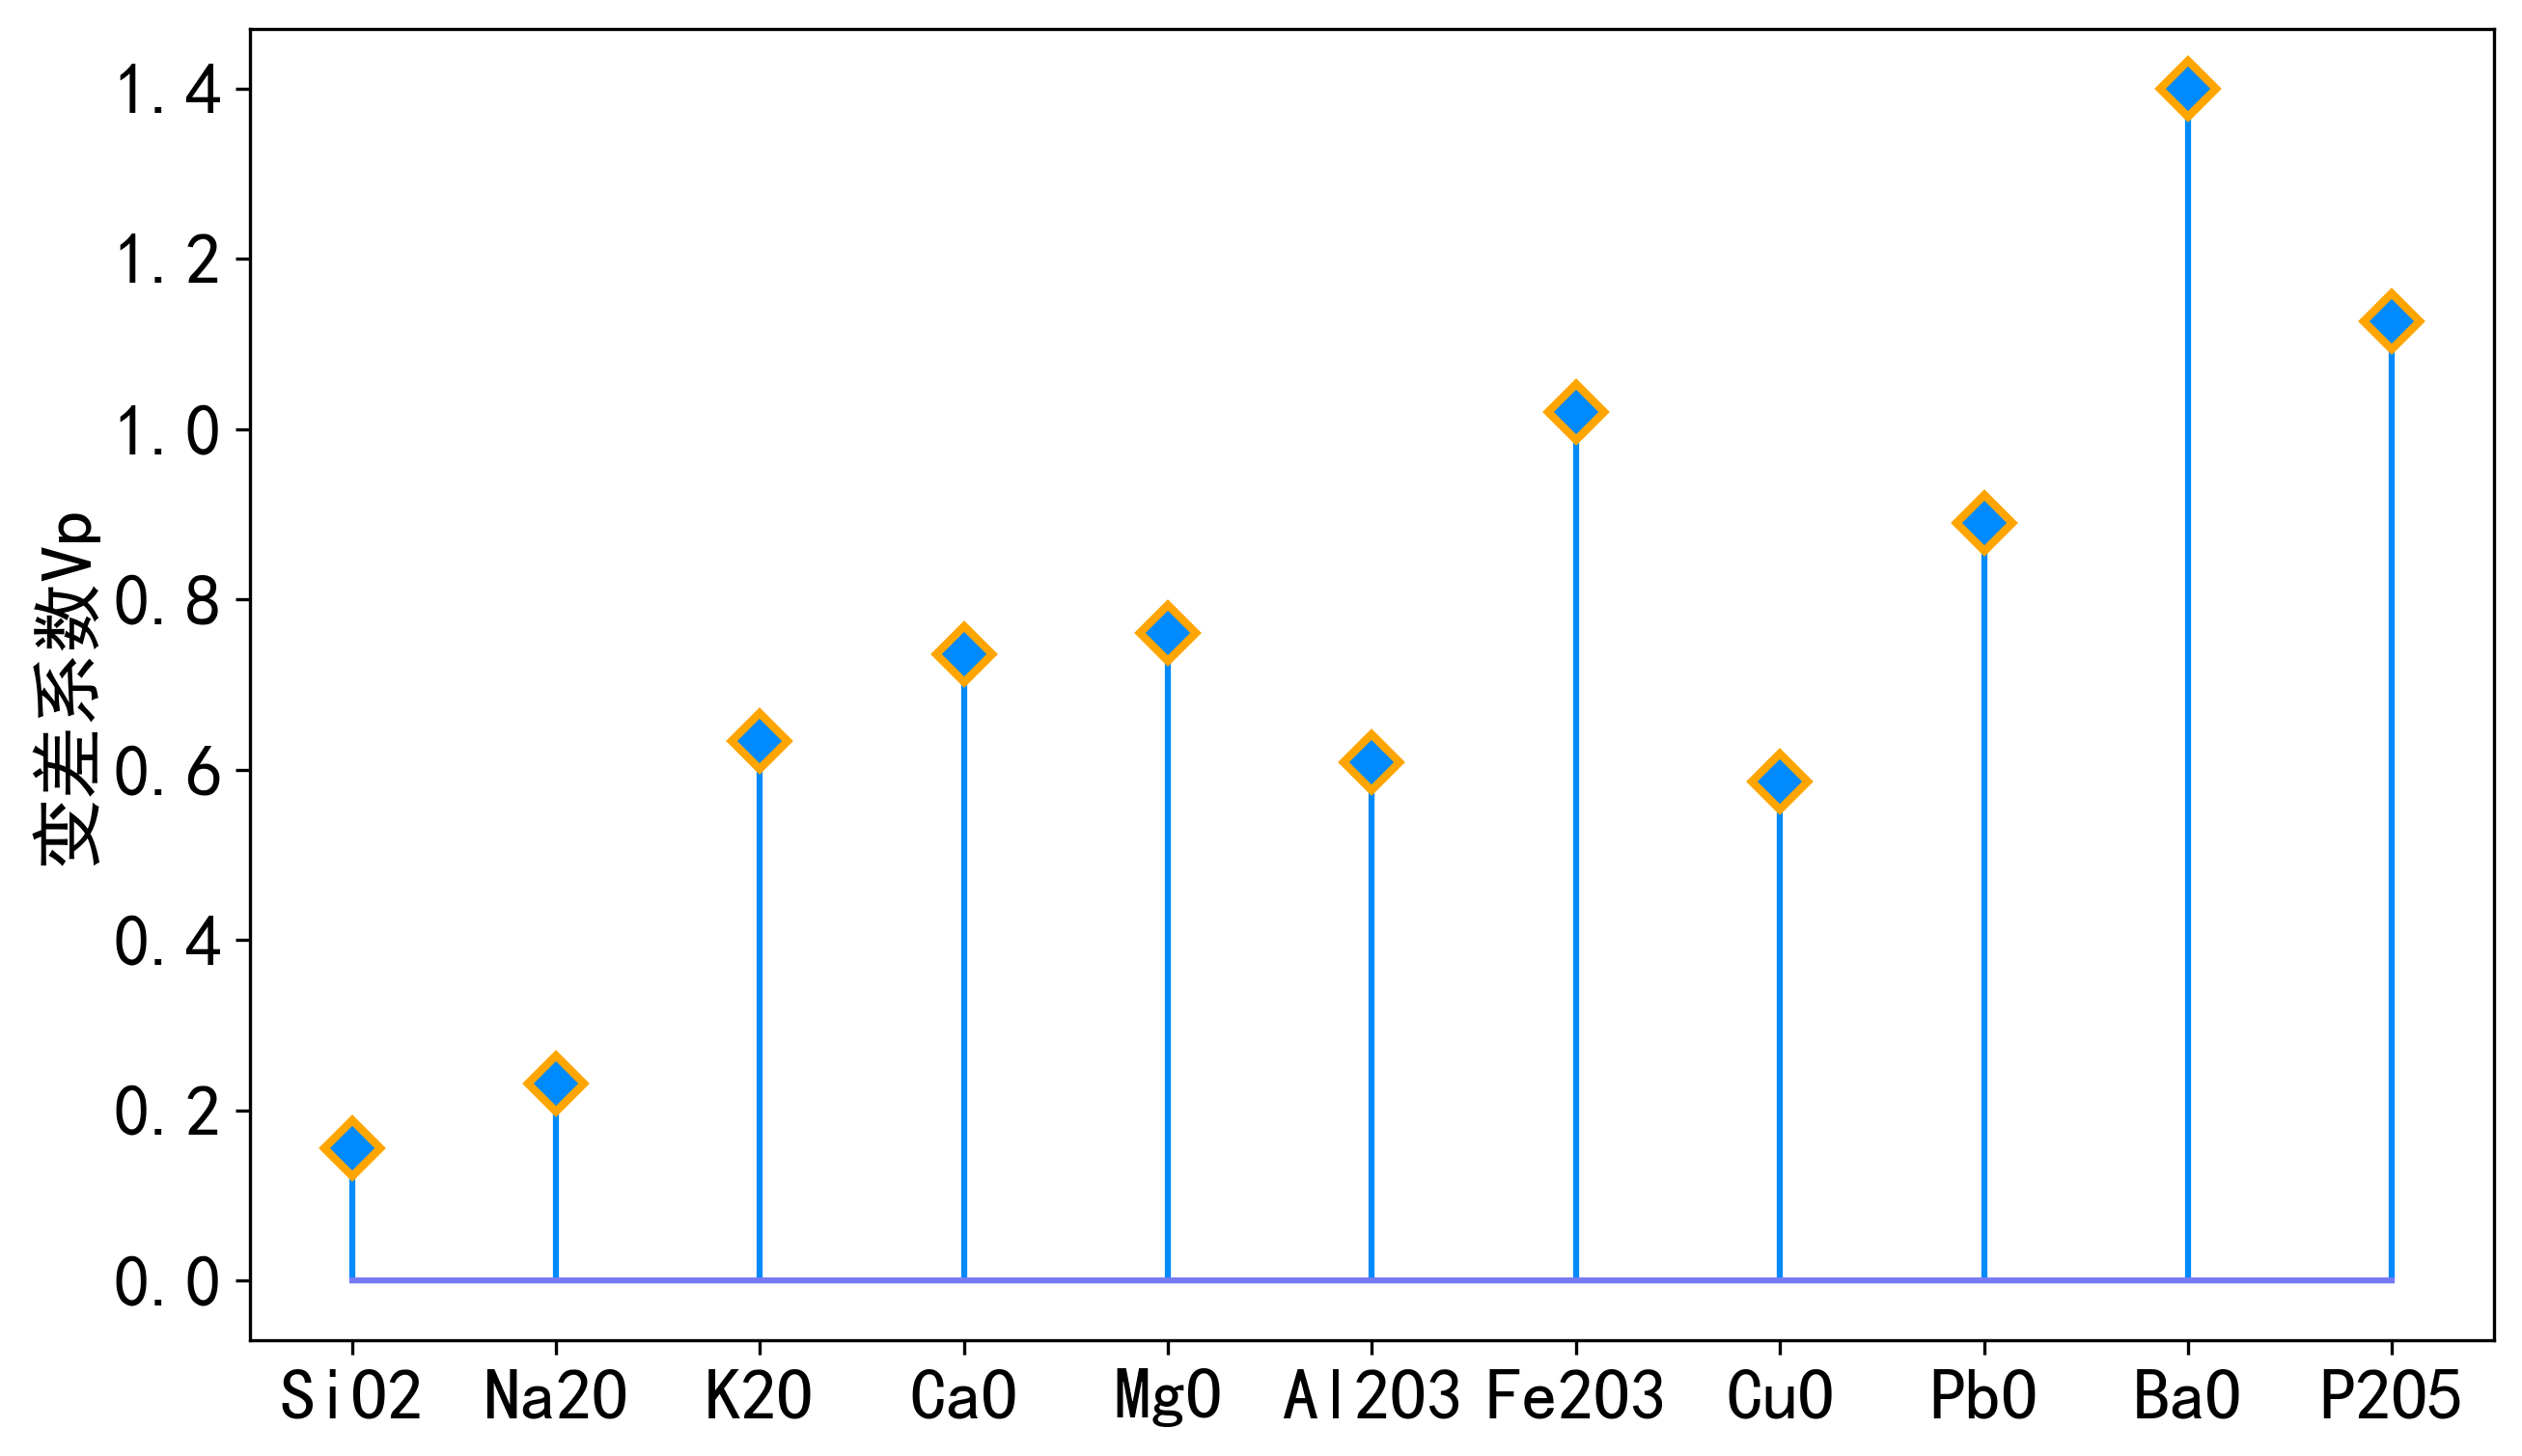

In [19]:
# 高钾变差系数图
#  = plt.stem(values)
plt.figure(figsize=(10,6), dpi= 300)
(markers, stemlines, baseline) = plt.stem(Vp.index, Vp.values, basefmt= '#767bf5', linefmt='#008afb')
plt.setp(markers, marker='D', markersize=10, markerfacecolor="#008afb", markeredgewidth=2, markeredgecolor= 'orange')
plt.ylabel('变差系数Vp', fontsize= 18)
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)
# plt.savefig(r'../图片/Q2_2_高钾变差系数.png',dpi= 300)

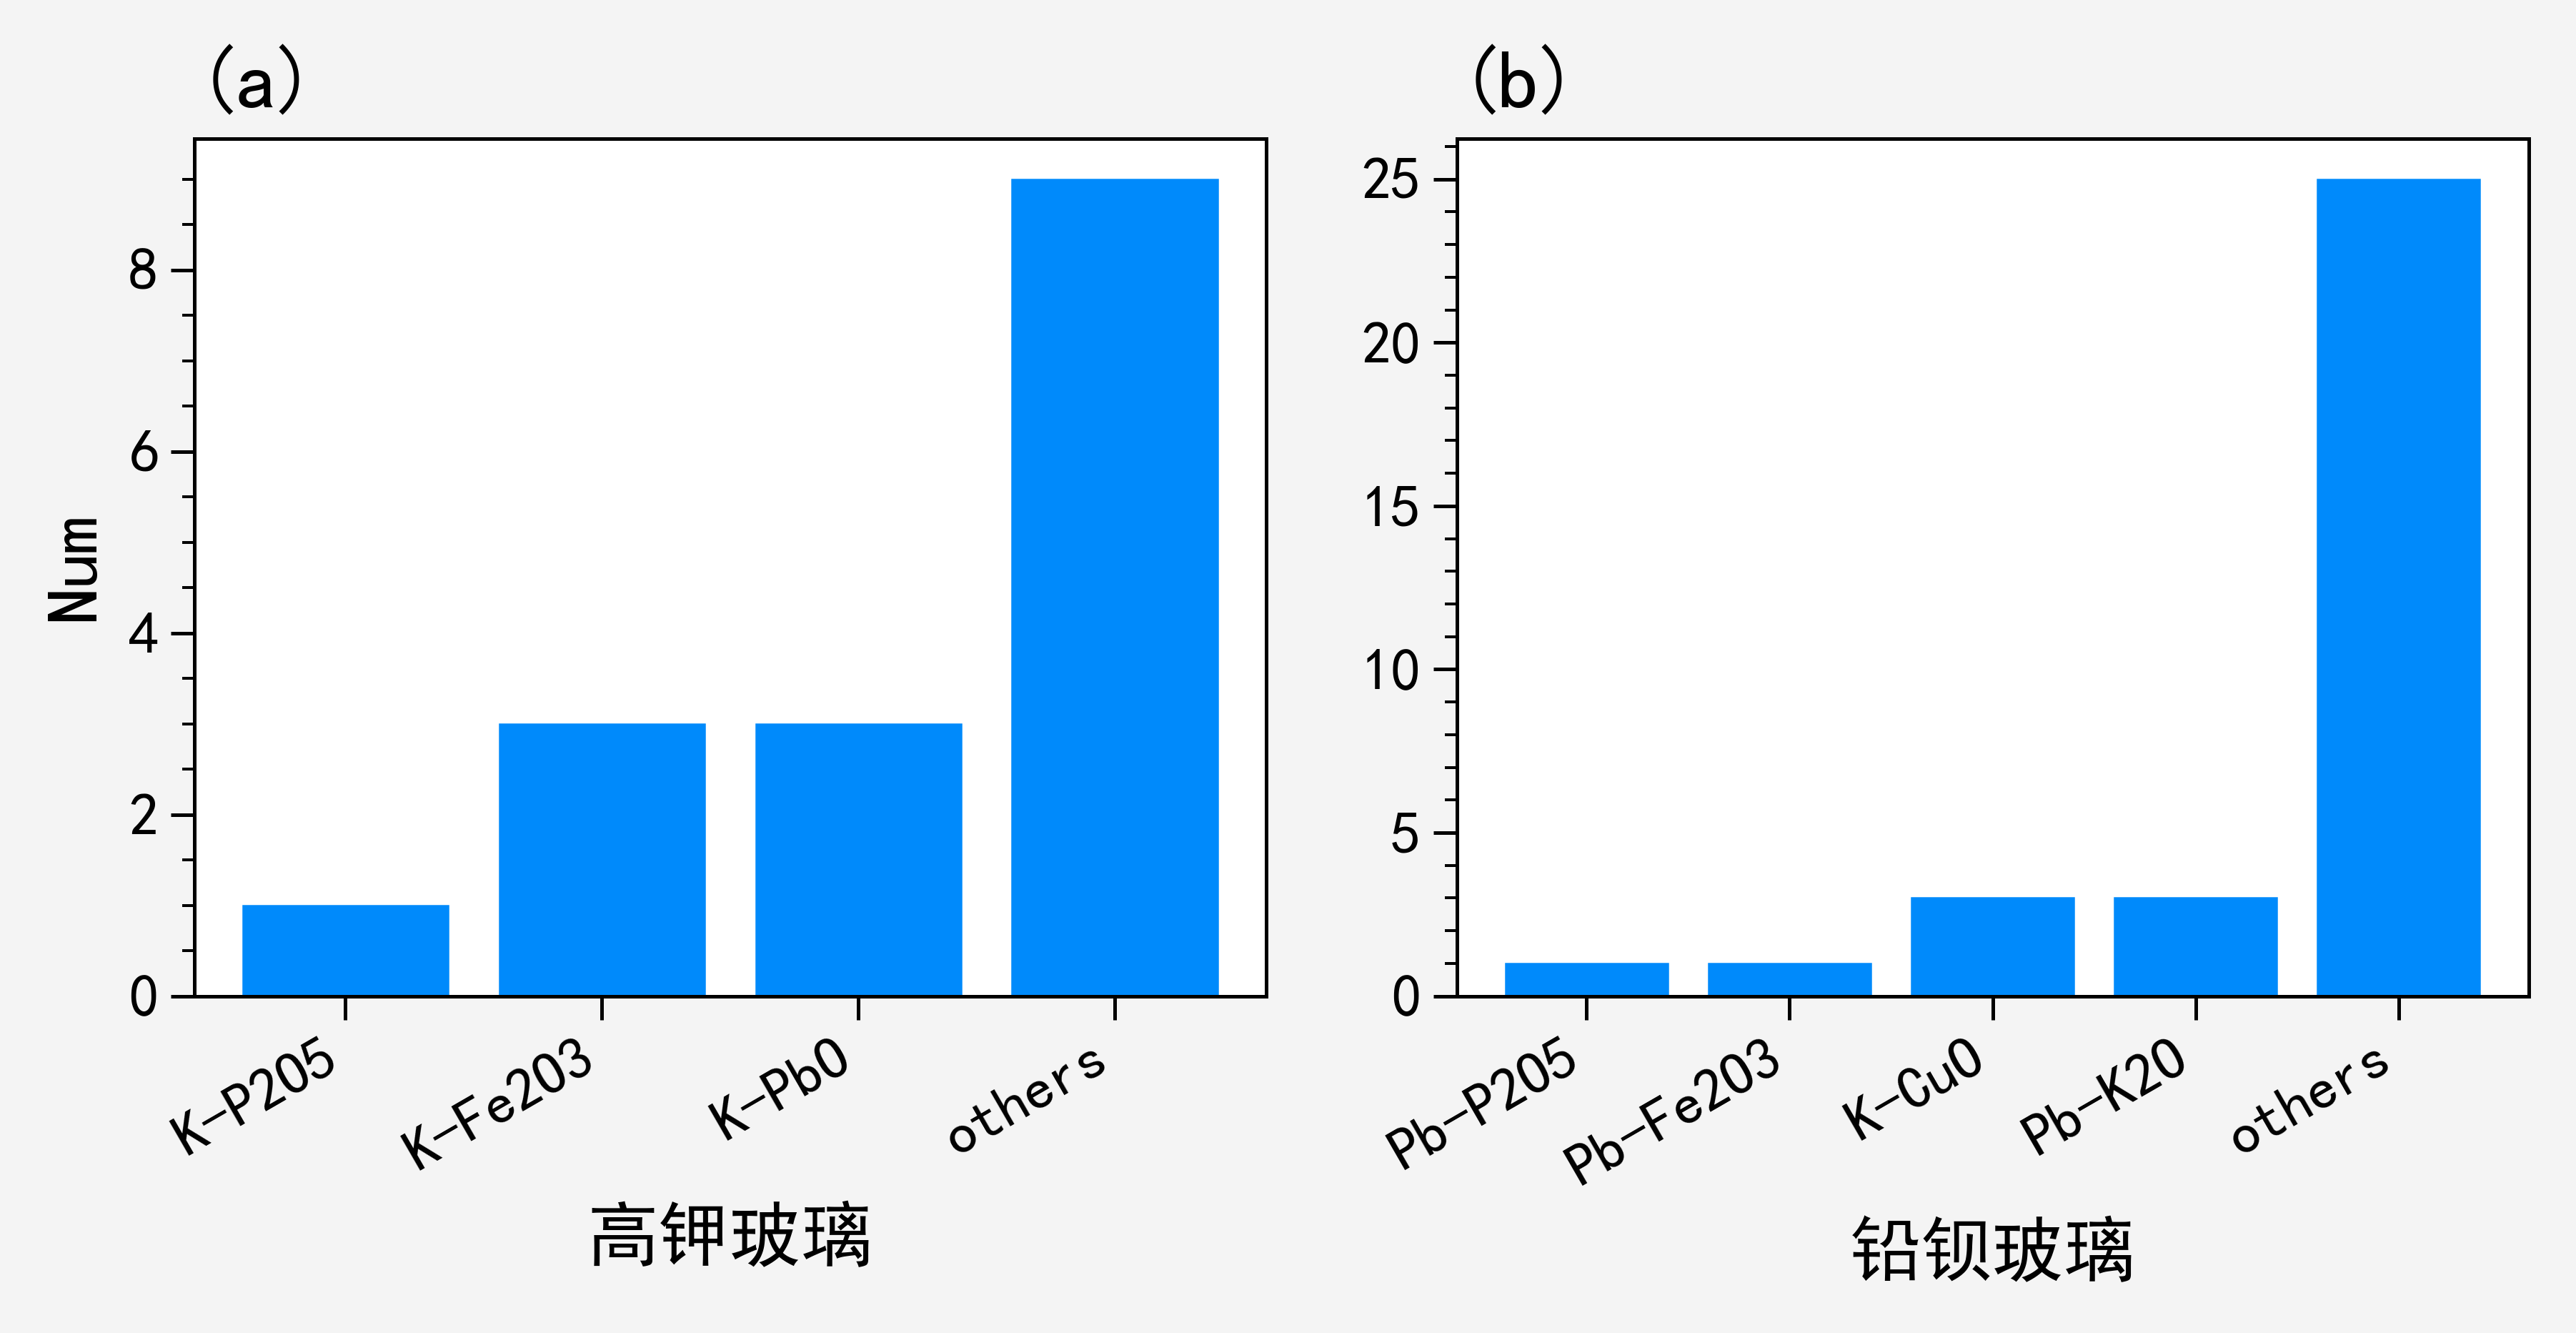

In [21]:
# 亚分类绘图
type_num_K = pd.DataFrame(data= {'K-P2O5':1,'K-Fe2O3':3,\
                        'K-PbO':3,'others':9}, index= ['num'])
type_num_Pb = pd.DataFrame(data= {'Pb-P2O5':1,'Pb-Fe2O3':1,\
                        'K-CuO':3,'Pb-K2O':3,'others':25}, index= ['num'])
# 绘图
fig, ax = pplt.subplots(refheight= 2, refwidth= 2.5, ncols= 2,dpi= 300,share= False)
ax[0].bar(type_num_K.T, c='#008afb')
ax[1].bar(type_num_Pb.T, c='#008afb')
ax[0].format(xlabel= '高钾玻璃', xlabelsize= 12, ylabel= 'Num',ylabelsize= 12,)
ax[1].format(xlabel= '铅钡玻璃', xlabelsize= 12)
ax.format(yticklabelsize= 10,xticklabelsize= 10,grid= False,xrotation= 30,
          abc= '(a)', abcsize= 14)
# plt.savefig('../图片/Q2_2_亚分类.png', dpi= 300)

#### 灵敏性分析

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
Dropp

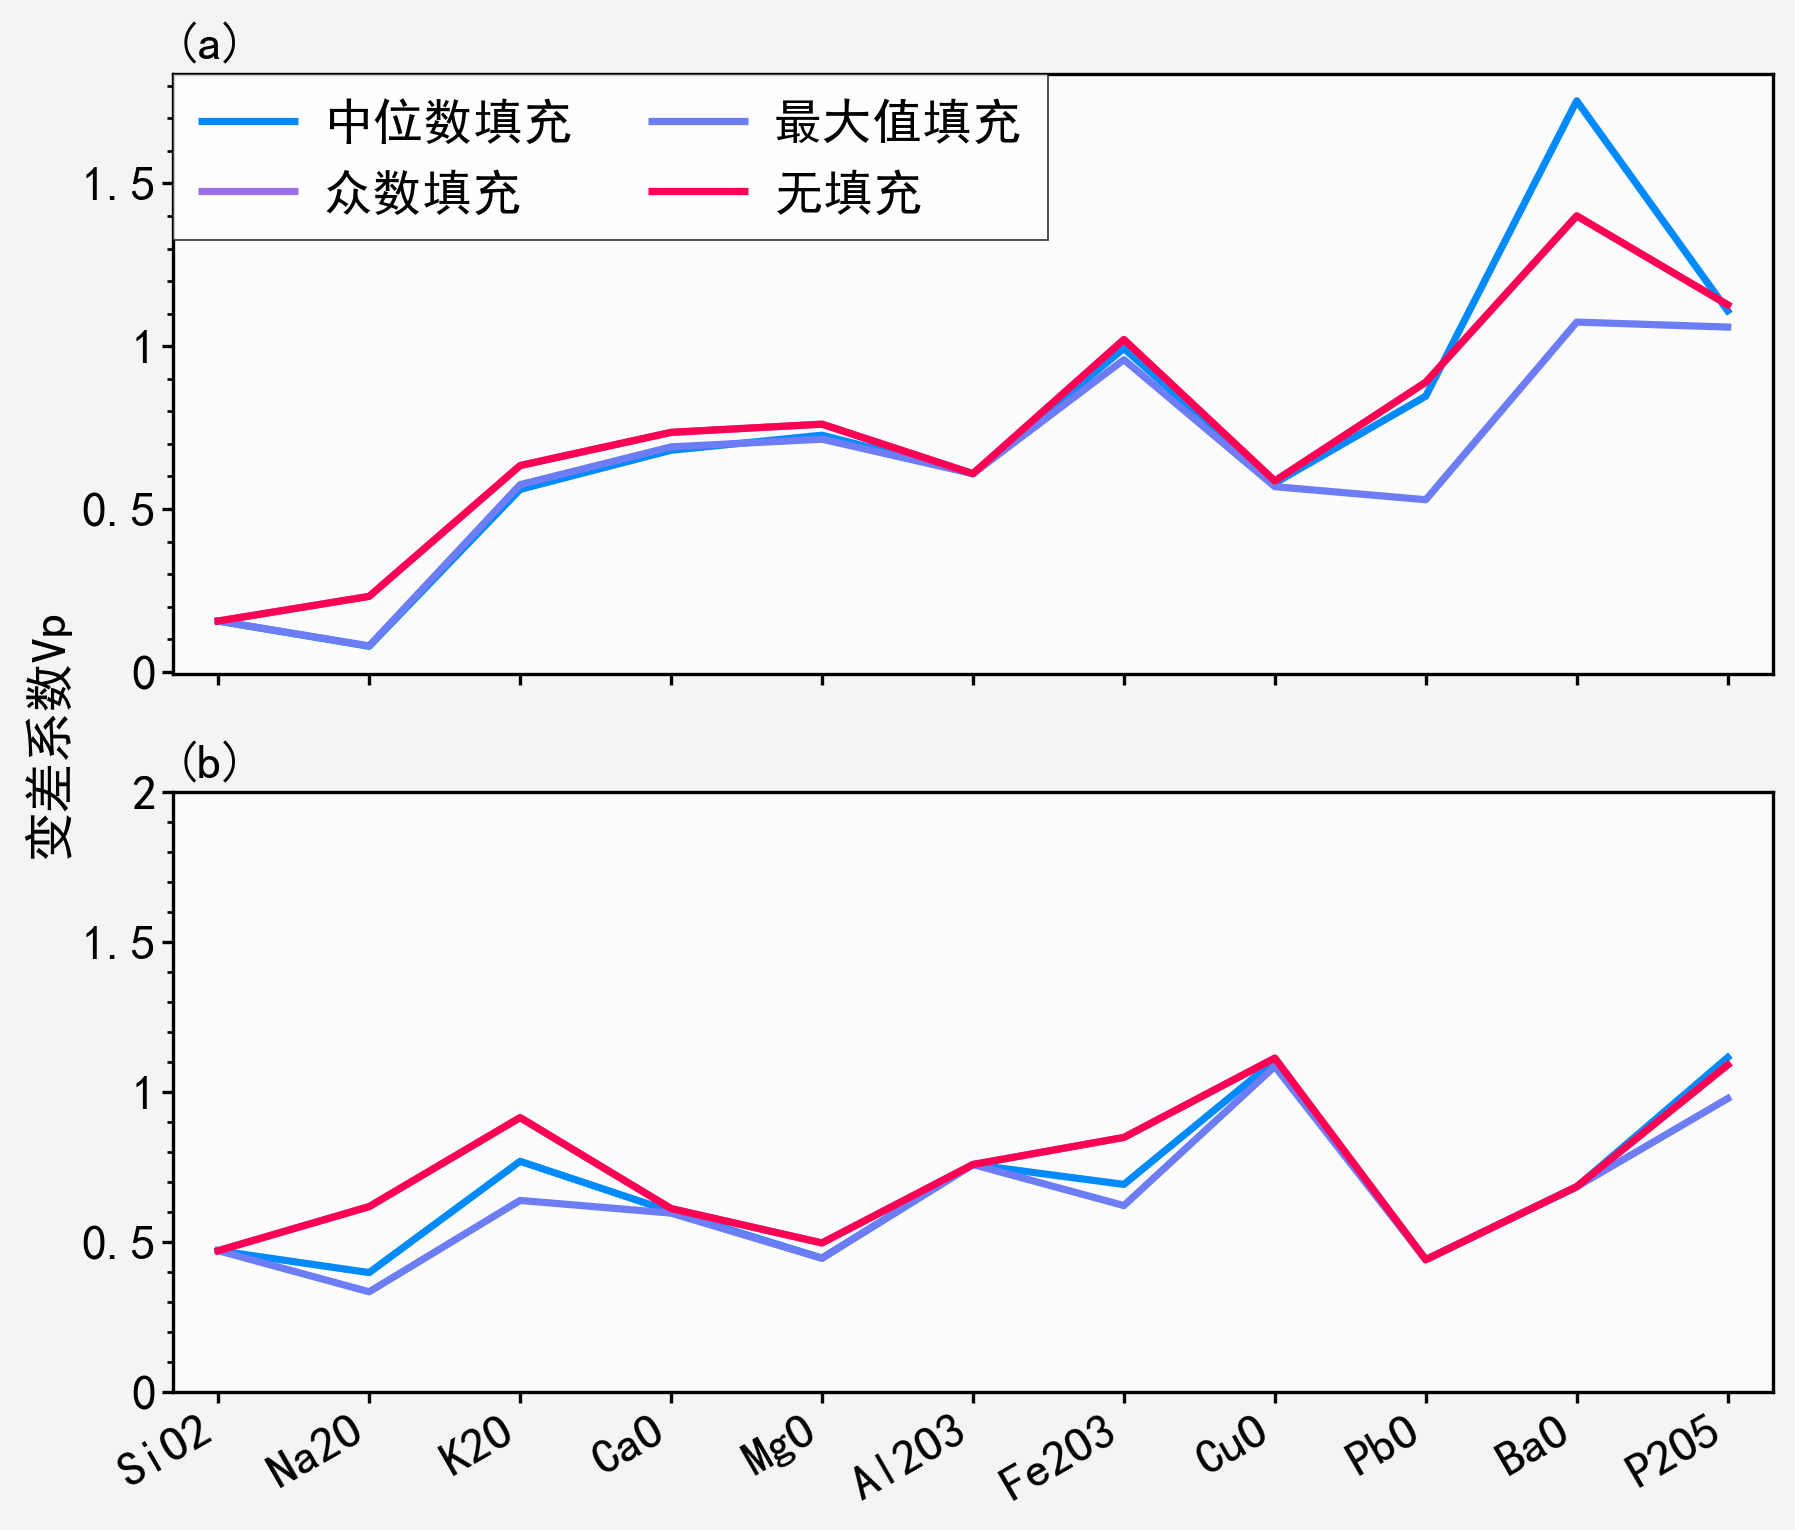

In [10]:
# 绘图
fig, ax = pplt.subplots(refheight= 3, refwidth= 8,nrows= 2)      
path = ['高钾', '铅钡']
for j in np.arange(0,2):              
    for i in np.arange(0, 4):  #3种填充方式
        data = pd.read_excel(r'../数据/表2_update.xlsx', index_col= '文物采样点')
        data = data[data['类型']== path[j]]
        if i == 1:
            data.fillna(data.mode(), inplace= True)
            fillna_mode = data.std(skipna= True)/data.mean(skipna= True) #变率系数
        elif i == 2:
            data.fillna(data.mean(skipna= True), inplace= True)
            fillna_mean = data.std(skipna= True)/data.mean(skipna= True)
        elif i==3:
            data.fillna(data.median(skipna= True), inplace= True)
            fillna_median = data.std(skipna= True)/data.mean(skipna= True)
        else:
            nofill = data.std(skipna= True)/data.mean(skipna= True)
        
    # 折线图
    ax[j].plot(fillna_median, lw= 2.6,label= '中位数填充', c= '#008afb') 
    ax[j].plot(fillna_mean, lw= 2.6,label='最大值填充', c= '#6c7df6') 
    ax[j].plot(fillna_mode, lw= 2.6,label='众数填充', c= '#9d6eea') 
    ax[j].plot(nofill, lw= 2.6,label= '无填充', c= '#ff0053') 

ax[0].legend(loc='best',ncols= 2, prop={'size': 18})
ax[1].format(ylim= (0,2))
ax.format(ylabel= '变差系数Vp', xlabelsize= 18,ylabelsize= 18,yticks = 0.5,
          xticklabelsize= 18,yticklabelsize= 18, xlim = (-0.3, 10.3),alpha= 0.8,
          linewidth = 1.2,xrotation= 30,grid= False,abc= '(a)',abcsize= 18,)
# plt.savefig(r'../图片/Q2_2_变差系数灵敏度分析_高钾铅钡未风化.png', dpi= 300)